In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
sns.set_context("talk")
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")
 
%matplotlib inline

### Goal: Predict if a new customer will become loyal customers in the future,i.e. predict the probability of new customer buying again within 6 months.

In [2]:
test_data = pd.read_csv('test_format1.csv')
train_data = pd.read_csv('train_format1.csv')
user_info = pd.read_csv('user_info_format1.csv')
user_log = pd.read_csv('user_log_format1.csv')

## 1. EDA
- check data type and shape
- check missing value: should use -1 or 2(gender) to fill
- check data distribution, outlier?
- check label balance: imblanced
- explore current features and engineered relevant features 
    - aggregate sales
    - user and merchant features
- merge all data, fill na (0)
- dimension reduction: check correlation, remove? pca?

### 1.1 check data type and shape

In [4]:
print(test_data.shape)
print(test_data.info())
test_data.head()

(261477, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261477 entries, 0 to 261476
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      261477 non-null  int64  
 1   merchant_id  261477 non-null  int64  
 2   prob         0 non-null       float64
dtypes: float64(1), int64(2)
memory usage: 6.0 MB
None


,user_id,merchant_id,prob
0,163968,4605,NaN
1,360576,1581,NaN
2,98688,1964,NaN
3,98688,3645,NaN
4,295296,3361,NaN


In [5]:
print(train_data.shape)
print(train_data.info())
train_data.head()

(260864, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260864 entries, 0 to 260863
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      260864 non-null  int64
 1   merchant_id  260864 non-null  int64
 2   label        260864 non-null  int64
dtypes: int64(3)
memory usage: 6.0 MB
None


,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [6]:
print(user_info.shape)
print(user_info.info())
user_info.head()

(424170, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424170 entries, 0 to 424169
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    424170 non-null  int64  
 1   age_range  421953 non-null  float64
 2   gender     417734 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 9.7 MB
None


,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [7]:
print(user_log.shape)
print(user_log.info())
user_log.head()

(54925330, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54925330 entries, 0 to 54925329
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   seller_id    int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
dtypes: float64(1), int64(6)
memory usage: 2.9 GB
None


,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,829,0
1,328862,844400,1271,2882,2661.0,829,0
2,328862,575153,1271,2882,2661.0,829,0
3,328862,996875,1271,2882,2661.0,829,0
4,328862,1086186,1271,1253,1049.0,829,0


action_type: {0, 1, 2, 3}，0 click，1 add to cart，2 purchase，3 add to favorate

time_stamp: mmdd    gender: 0 female 1 male

### 1.2 check missing values

In [8]:
#missing data proportion
print('age range missing proportion is %.2f%%' % ((user_info['age_range'].isna().sum())/user_info.shape[0]*100))
print('gender missing proportion is %.2f%%' % ((user_info['gender'].isna().sum())/user_info.shape[0]*100))

age range missing proportion is 0.52%
gender missing proportion is 1.52%


In [9]:
user_log.isna().sum()

user_id            0
item_id            0
cat_id             0
seller_id          0
brand_id       91015
time_stamp         0
action_type        0
dtype: int64

In [10]:
print('brand id missing proportion is %.2f%%' % ((user_log['brand_id'].isna().sum())/user_log.shape[0]*100))

brand id missing proportion is 0.17%


fill missing value with -1 later.

### 1.3 check data distribution, outlier?

In [11]:
user_info.describe()

,user_id,age_range,gender
count,424170.000000,421953.000000,417734.000000
mean,212085.500000,2.930262,0.341179
std,122447.476178,1.942978,0.524112
min,1.000000,0.000000,0.000000
25%,106043.250000,2.000000,0.000000
50%,212085.500000,3.000000,0.000000
75%,318127.750000,4.000000,1.000000
max,424170.000000,8.000000,2.000000


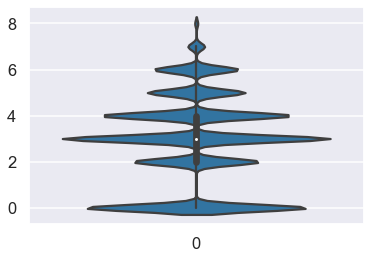

In [12]:
sns.violinplot(user_info['age_range'])

([<matplotlib.patches.Wedge at 0x23896fa7b20>,
 [Text(-0.6193596168744666, 0.9090619698266528, 'Female'),
  Text(0.5742128794511393, -0.9382321509479579, 'Male'),
  Text(1.0986867621745213, -0.05373451984029462, 'NA')],
 [Text(-0.33783251829516353, 0.49585198354181054, '69%'),
  Text(0.31320702515516685, -0.5117629914261588, '29%'),
  Text(0.5992836884588297, -0.029309738094706154, '2%')])

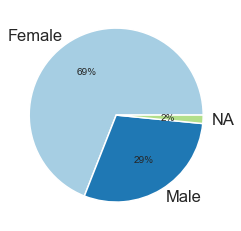

In [13]:
plt.pie([(user_info['gender']==0).sum(),(user_info['gender']==1).sum(),user_info['gender'].isna().sum()], 
        labels=['Female','Male','NA'],autopct='%.0f%%',colors=sns.color_palette("Paired"))

Most customers are female.

In [14]:
user_log.describe()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
count,5.492533e+07,5.492533e+07,5.492533e+07,5.492533e+07,5.483432e+07,5.492533e+07,5.492533e+07
mean,2.121568e+05,5.538613e+05,8.770308e+02,2.470941e+03,4.153348e+03,9.230953e+02,2.854458e-01
std,1.222872e+05,3.221459e+05,4.486269e+02,1.473310e+03,2.397679e+03,1.954305e+02,8.075806e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.110000e+02,0.000000e+00
25%,1.063360e+05,2.731680e+05,5.550000e+02,1.151000e+03,2.027000e+03,7.300000e+02,0.000000e+00
50%,2.126540e+05,5.555290e+05,8.210000e+02,2.459000e+03,4.065000e+03,1.010000e+03,0.000000e+00
75%,3.177500e+05,8.306890e+05,1.252000e+03,3.760000e+03,6.196000e+03,1.109000e+03,0.000000e+00
max,4.241700e+05,1.113166e+06,1.671000e+03,4.995000e+03,8.477000e+03,1.112000e+03,3.000000e+00


### 1.4 check label balance

In [15]:
print('label 0 proportion is %.2f%%'%((train_data['label']==0).sum()/train_data.shape[0]*100))
print('label 1 proportion is %.2f%%'%((train_data['label']==1).sum()/train_data.shape[0]*100))

label 0 proportion is 93.88%
label 1 proportion is 6.12%


Labeled data is imbalanced.should use bootstrap

### 1.5 explore current features

- merchant_id
- user_id
- age_range
- gender

In [16]:
train_data.head()

,user_id,merchant_id,label
0,34176,3906,0
1,34176,121,0
2,34176,4356,1
3,34176,2217,0
4,230784,4818,0


In [17]:
print('top5 shops\nshop id\tpurchase time')
print(train_data['merchant_id'].value_counts().head(5))

top5 shops
shop id	purchase time
4044    3379
3828    3254
4173    2542
1102    2483
4976    1925
Name: merchant_id, dtype: int64


Text(0.5, 1.0, 'merchant vs label')

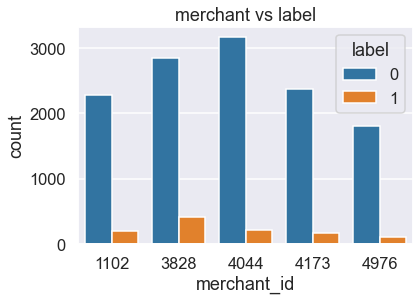

In [18]:
merch_data=train_data[train_data['merchant_id'].isin([4044,3828,4173,1102,4976])][['merchant_id','label']]
sns.countplot(data=merch_data, x="merchant_id", hue="label")
plt.title('merchant vs label')

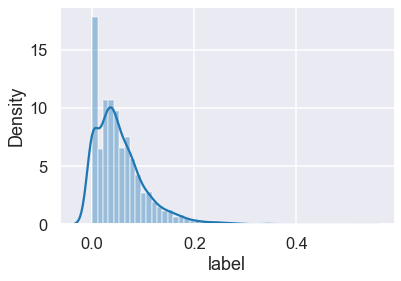

In [19]:
sns.distplot(train_data.groupby(['merchant_id'])['label'].mean()) #distribution of shop repurchase rate
#low, mostly 0~0.2

merchant_id has impact on label

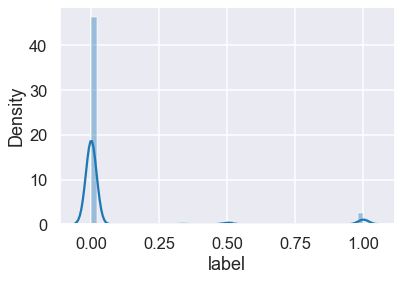

In [20]:
sns.distplot(train_data.groupby(['user_id'])['label'].mean()) #distribution of user repurchase rate
#low, mostly one time buyer

user_id has impact on label

In [21]:
user_info.head()

,user_id,age_range,gender
0,376517,6.0,1.0
1,234512,5.0,0.0
2,344532,5.0,0.0
3,186135,5.0,0.0
4,30230,5.0,0.0


In [20]:
train_data= pd.merge(train_data,user_info,on="user_id",how="left")
print(train_data.shape)
train_data.head()

(260864, 5)


,user_id,merchant_id,label,age_range,gender
0,34176,3906,0,6.0,0.0
1,34176,121,0,6.0,0.0
2,34176,4356,1,6.0,0.0
3,34176,2217,0,6.0,0.0
4,230784,4818,0,0.0,0.0


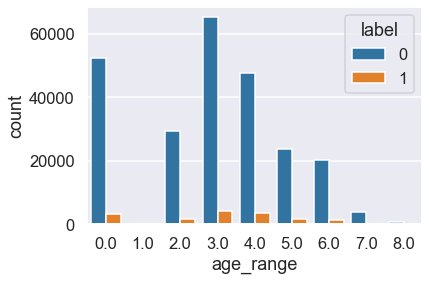

In [23]:
sns.countplot(data=train_data, x='age_range',hue='label')

age has impact on label

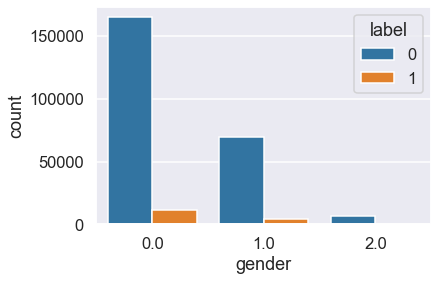

In [24]:
sns.countplot(data=train_data, x='gender',hue='label')

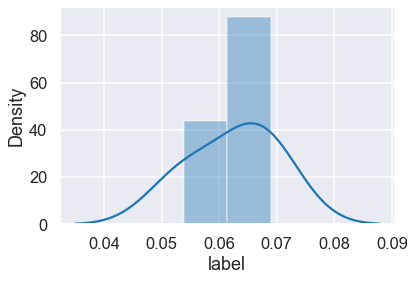

In [25]:
sns.distplot(train_data.groupby(['gender'])['label'].mean()) #distribution of gender repurchase rate
#low, mostly one time buyer

gender has impact on label

### 1.6 feature engineer

In [108]:
user_log.sort_values(['user_id','time_stamp']).head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
23288890,1,181459,276,2245,4750.0,1009,0
23288891,1,779078,276,2245,4750.0,1009,0
23288892,1,779078,276,2245,4750.0,1009,0
23288893,1,452837,276,2245,4750.0,1009,0
23288894,1,543397,276,2245,4750.0,1009,0


(action_type: {0, 1, 2, 3}，0 click，1 add to cart，2 purchase，3 add to favorate)

#### aggregate sales to create features
#### for each user, seller_id(merchant_id) pair
- total_item_id count()
- unique_item_id count(distinct)
- total_cat_id count()
- unique_cat_id count(distinct)
- click=# action0
- shopping_cart=# action1
- purchase=# action2
- favourite=# action3


In [3]:
df1=user_log.groupby(['user_id','seller_id'])['item_id'].count().reset_index(name='total_item_id ')
df1.rename(columns={'seller_id': 'merchant_id'},inplace=True)
df1.head()

,user_id,merchant_id,total_item_id
0,1,471,1
1,1,739,1
2,1,925,4
3,1,1019,14
4,1,1156,1


In [4]:
df2=user_log.groupby(['user_id','seller_id'])['item_id'].nunique().reset_index(name='unique_item_id')
df2.rename(columns={'seller_id': 'merchant_id'},inplace=True)
df2.head()

,user_id,merchant_id,unique_item_id
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


In [5]:
df3=user_log.groupby(['user_id','seller_id'])['cat_id'].count().reset_index(name='total_cat_id')
df3.rename(columns={'seller_id': 'merchant_id'},inplace=True)
df3.head()

,user_id,merchant_id,total_cat_id
0,1,471,1
1,1,739,1
2,1,925,4
3,1,1019,14
4,1,1156,1


In [6]:
df4=user_log.groupby(['user_id','seller_id'])['cat_id'].nunique().reset_index(name='unique_cat_id')
df4.rename(columns={'seller_id': 'merchant_id'},inplace=True)
df4.head()

,user_id,merchant_id,unique_cat_id
0,1,471,1
1,1,739,1
2,1,925,1
3,1,1019,1
4,1,1156,1


In [7]:
df5=user_log[user_log['action_type']==0]
df5=df5.groupby(['user_id', 'seller_id'])['action_type'].count().reset_index(name='click')
df5.rename(columns={'seller_id': 'merchant_id'},inplace=True)
df5.head()

,user_id,merchant_id,click
0,1,471,1
1,1,739,1
2,1,925,3
3,1,1019,10
4,1,1156,1


In [8]:
df6=user_log[user_log['action_type']==1]
df6=df6.groupby(['user_id', 'seller_id'])['action_type'].count().reset_index(name='shopping_cart')
df6.rename(columns={'seller_id': 'merchant_id'},inplace=True)
df6.head()

,user_id,merchant_id,shopping_cart
0,18,2860,2
1,18,4919,1
2,23,2664,2
3,23,4888,1
4,41,4941,1


In [9]:
df7=user_log[user_log['action_type']==2]
df7=df7.groupby(['user_id', 'seller_id'])['action_type'].count().reset_index(name='purchase')
df7.rename(columns={'seller_id': 'merchant_id'},inplace=True)
df7.head()

,user_id,merchant_id,purchase
0,1,925,1
1,1,1019,4
2,1,4026,1
3,2,420,3
4,2,1179,1


In [10]:
df8=user_log[user_log['action_type']==3]
df8=df8.groupby(['user_id', 'seller_id'])['action_type'].count().reset_index(name='favorite')
df8.rename(columns={'seller_id': 'merchant_id'},inplace=True)
df8.head()

,user_id,merchant_id,favorite
0,2,2412,1
1,2,3716,1
2,3,2313,1
3,5,1,1
4,5,186,1


#### user features
- average monthly usage frequency (how many times a user intereact with app per month) df9
- overall purchase/click rate  df12

In [11]:
user_log['time_stamp'] = pd.to_datetime(user_log['time_stamp'], format='%m%d')
user_log.head()

,user_id,item_id,cat_id,seller_id,brand_id,time_stamp,action_type
0,328862,323294,833,2882,2661.0,1900-08-29,0
1,328862,844400,1271,2882,2661.0,1900-08-29,0
2,328862,575153,1271,2882,2661.0,1900-08-29,0
3,328862,996875,1271,2882,2661.0,1900-08-29,0
4,328862,1086186,1271,1253,1049.0,1900-08-29,0


In [12]:
df9=user_log.groupby(['user_id',user_log['time_stamp'].dt.month]).size().reset_index(name='monthly_frequency')

In [13]:
df9=df9.groupby('user_id')['monthly_frequency'].mean().reset_index(name='avg_monthly_frequency')
df9.head()

,user_id,avg_monthly_frequency
0,1,16.500000
1,2,10.500000
2,3,9.714286
3,4,10.000000
4,5,24.714286


In [14]:
click_data=user_log[user_log['action_type']==0]
df10=click_data.groupby('user_id').size().reset_index(name='click_num')
df10.head()

,user_id,click_num
0,1,27
1,2,47
2,3,63
3,4,49
4,5,150


In [15]:
purchase_data=user_log[user_log['action_type']==2]
df11=purchase_data.groupby('user_id').size().reset_index(name='purchase_num')
df11.head()

,user_id,purchase_num
0,1,6
1,2,14
2,3,4
3,4,1
4,5,13


In [16]:
df12=df10.merge(df11,on='user_id',how='left')
df12['purchase_click_rate']=df12['purchase_num']/df12['click_num']
df12.head()

,user_id,click_num,purchase_num,purchase_click_rate
0,1,27,6,0.222222
1,2,47,14,0.297872
2,3,63,4,0.063492
3,4,49,1,0.020408
4,5,150,13,0.086667


In [17]:
df12=df12[['user_id','purchase_click_rate']]
df12.head()

,user_id,purchase_click_rate
0,1,0.222222
1,2,0.297872
2,3,0.063492
3,4,0.020408
4,5,0.086667


#### merchant feature
- overall purchase/click rate  df15

In [18]:
df13=click_data.groupby('seller_id').size().reset_index(name='click_num')
df14=purchase_data.groupby('seller_id').size().reset_index(name='purchase_num')
df15=df13.merge(df14,on='seller_id',how='left')
df15['purchase_click_rate']=df15['purchase_num']/df15['click_num']
df15=df15[['seller_id','purchase_click_rate']]
df15.rename(columns={'seller_id': 'merchant_id'},inplace=True)
df15.head()

,merchant_id,purchase_click_rate
0,1,0.057440
1,2,0.093103
2,3,0.027928
3,4,0.111111
4,5,0.019244


### 1.7 fill missing values and merge all features with training (labeled) and testing (unlabeled) data

In [21]:
train_data.head()

,user_id,merchant_id,label,age_range,gender
0,34176,3906,0,6.0,0.0
1,34176,121,0,6.0,0.0
2,34176,4356,1,6.0,0.0
3,34176,2217,0,6.0,0.0
4,230784,4818,0,0.0,0.0


In [22]:
train_data['gender'] = train_data['gender'].fillna(2)

In [23]:
train_data['age_range'] = train_data['age_range'].fillna(-1)

In [24]:
train_data=train_data.merge(df1,on=['user_id','merchant_id'],how='left')

In [25]:
train_data=train_data.merge(df2,on=['user_id','merchant_id'],how='left')
train_data=train_data.merge(df3,on=['user_id','merchant_id'],how='left')
train_data=train_data.merge(df4,on=['user_id','merchant_id'],how='left')
train_data=train_data.merge(df5,on=['user_id','merchant_id'],how='left')
train_data=train_data.merge(df6,on=['user_id','merchant_id'],how='left')
train_data=train_data.merge(df7,on=['user_id','merchant_id'],how='left')
train_data=train_data.merge(df8,on=['user_id','merchant_id'],how='left')

In [26]:
train_data=train_data.merge(df9,on='user_id',how='left')
train_data=train_data.merge(df12,on='user_id',how='left')
train_data=train_data.merge(df15,on='merchant_id',how='left')

In [28]:
train_data=train_data.fillna(0)
train_data.isna().sum().sum()

0

In [29]:
train_data.head()

,user_id,merchant_id,label,age_range,gender,total_item_id,unique_item_id,total_cat_id,unique_cat_id,click,shopping_cart,purchase,favorite,avg_monthly_frequency,purchase_click_rate_x,purchase_click_rate_y
0,34176,3906,0,6.0,0.0,39,20,39,6,36.0,0.0,1,2.0,64.428571,0.082927,0.027572
1,34176,121,0,6.0,0.0,14,1,14,1,13.0,0.0,1,0.0,64.428571,0.082927,0.066145
2,34176,4356,1,6.0,0.0,18,2,18,1,12.0,0.0,6,0.0,64.428571,0.082927,0.158024
3,34176,2217,0,6.0,0.0,2,1,2,1,1.0,0.0,1,0.0,64.428571,0.082927,0.071243
4,230784,4818,0,0.0,0.0,8,1,8,1,7.0,0.0,1,0.0,10.800000,0.148936,0.063164


In [40]:
train_data.shape

(260864, 16)

train_data preparation done!

In [30]:
test_data=test_data.merge(user_info, on='user_id',how='left')

In [33]:
test_data=test_data.drop(columns=['prob'])

In [35]:
test_data['gender'] = test_data['gender'].fillna(2)
test_data['age_range'] = test_data['age_range'].fillna(-1)

In [36]:
test_data=test_data.merge(df1,on=['user_id','merchant_id'],how='left')
test_data=test_data.merge(df2,on=['user_id','merchant_id'],how='left')
test_data=test_data.merge(df3,on=['user_id','merchant_id'],how='left')
test_data=test_data.merge(df4,on=['user_id','merchant_id'],how='left')
test_data=test_data.merge(df5,on=['user_id','merchant_id'],how='left')
test_data=test_data.merge(df6,on=['user_id','merchant_id'],how='left')
test_data=test_data.merge(df7,on=['user_id','merchant_id'],how='left')
test_data=test_data.merge(df8,on=['user_id','merchant_id'],how='left')
test_data=test_data.merge(df9,on='user_id',how='left')
test_data=test_data.merge(df12,on='user_id',how='left')
test_data=test_data.merge(df15,on='merchant_id',how='left')

In [37]:
test_data=test_data.fillna(0)
test_data.isna().sum().sum()

0

In [38]:
test_data.head()

,user_id,merchant_id,age_range,gender,total_item_id,unique_item_id,total_cat_id,unique_cat_id,click,shopping_cart,purchase,favorite,avg_monthly_frequency,purchase_click_rate_x,purchase_click_rate_y
0,163968,4605,0.0,0.0,2,1,2,1,1.0,0.0,1,0.0,13.500000,0.253968,0.148155
1,360576,1581,2.0,2.0,10,9,10,4,5.0,0.0,5,0.0,12.833333,0.084507,0.224485
2,98688,1964,6.0,0.0,6,1,6,1,5.0,0.0,1,0.0,14.000000,0.098039,0.151665
3,98688,3645,6.0,0.0,11,1,11,1,10.0,0.0,1,0.0,14.000000,0.098039,0.045334
4,295296,3361,2.0,1.0,50,8,50,4,47.0,0.0,1,2.0,25.142857,0.043210,0.032303


In [39]:
test_data.shape

(261477, 15)

test_data preparation done!

In [43]:
train_data.to_csv('train_data.csv', index=False)

In [44]:
test_data.to_csv('test_data.csv', index=False)

In [2]:
train_data = pd.read_csv('train_data.csv')

### 1.8 dimension reduction: check correlation, remove? pca?

In [3]:
y = train_data["label"]
X = train_data.drop(["user_id", "merchant_id", "label"], axis=1)
X.head()

,age_range,gender,total_item_id,unique_item_id,total_cat_id,unique_cat_id,click,shopping_cart,purchase,favorite,avg_monthly_frequency,purchase_click_rate_x,purchase_click_rate_y
0,6.0,0.0,39,20,39,6,36.0,0.0,1,2.0,64.428571,0.082927,0.027572
1,6.0,0.0,14,1,14,1,13.0,0.0,1,0.0,64.428571,0.082927,0.066145
2,6.0,0.0,18,2,18,1,12.0,0.0,6,0.0,64.428571,0.082927,0.158024
3,6.0,0.0,2,1,2,1,1.0,0.0,1,0.0,64.428571,0.082927,0.071243
4,0.0,0.0,8,1,8,1,7.0,0.0,1,0.0,10.800000,0.148936,0.063164


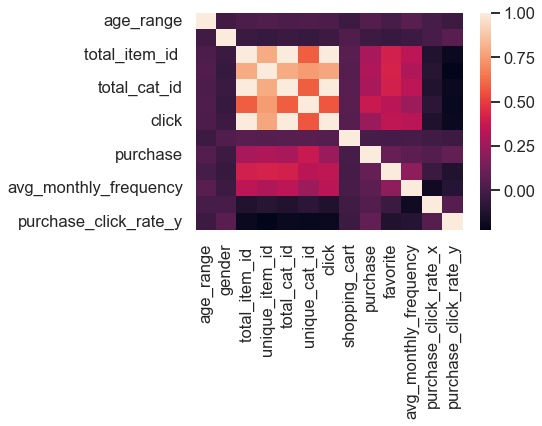

In [55]:
corr_train = X.corr()
sns.heatmap(corr_train)

remove click

In [4]:
X=X.drop('click',axis=1)

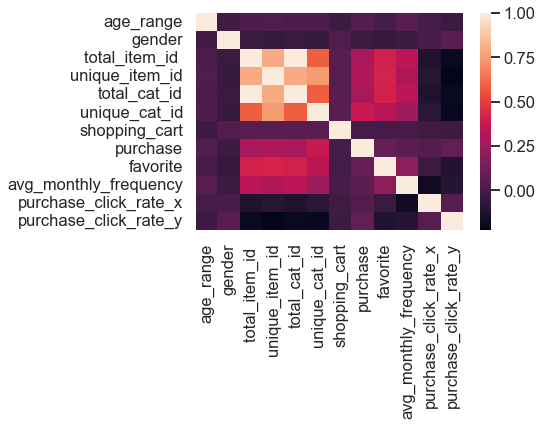

In [58]:
corr_train = X.corr()
sns.heatmap(corr_train)

do pca

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(n_components=5)
X_transformed = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print('total variance explained: ',sum(pca.explained_variance_ratio_))

[0.66895903 0.31499713 0.0118809  0.00197403 0.00085554]
total variance explained:  0.998666635510558


In [67]:
X_transformed.shape

(260864, 5)

## 2. Modeling
- Logistics regression
- KNN
- Decision tree
- Random forest
- SVM


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=0)

In [8]:
X_train.shape

(208691, 5)

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

### 2.1 Logistics regression

In [41]:
from sklearn.linear_model import LogisticRegression

Logit = LogisticRegression(solver='liblinear')
Logit.fit(X_train, y_train)
Predict = Logit.predict(X_test)
Predict_proba = Logit.predict_proba(X_test)
Score = accuracy_score(y_test, Predict)
print('accuracy:',Score)
precision = precision_score(y_test, Predict)
print('precision:',precision)
recall = recall_score(y_test, Predict)
print('recall:',recall)
f1 = f1_score(y_test, Predict)
print('f1:',f1)

accuracy: 0.9392214363751366
precision: 0.48484848484848486
recall: 0.005047318611987382
f1: 0.009990633780830474


### 2.2 KNN

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors': np.arange(1,10,1),
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='precision', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

{'metric': 'euclidean', 'n_neighbors': 8}


In [42]:
knn=KNeighborsClassifier(n_neighbors=8,metric='euclidean')
knn.fit(X_train, y_train)
Predict = knn.predict(X_test)
Score = accuracy_score(y_test, Predict)
print('accuracy:',Score)
precision = precision_score(y_test, Predict)
print('precision:',precision)
recall = recall_score(y_test, Predict)
print('recall:',recall)
f1 = f1_score(y_test, Predict)
print('f1:',f1)

accuracy: 0.9390105993521554
precision: 0.0
recall: 0.0
f1: 0.0


### 2.3 Decision tree

In [23]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [2, 4, 6, 8, 10]
}

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)


{'max_depth': 4, 'min_samples_leaf': 8}


In [43]:
dt = DecisionTreeClassifier(max_depth=4,min_samples_leaf=8)
dt.fit(X_train, y_train)
Predict = dt.predict(X_test)
Score = accuracy_score(y_test, Predict)
print('accuracy:',Score)
precision = precision_score(y_test, Predict)
print('precision:',precision)
recall = recall_score(y_test, Predict)
print('recall:',recall)
f1 = f1_score(y_test, Predict)
print('f1:',f1)

accuracy: 0.9392214363751366
precision: 0.0
recall: 0.0
f1: 0.0


### 2.4 Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [10, 50],
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [2, 4, 6, 8, 10]
}

rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

In [44]:
rf = RandomForestClassifier(n_estimators=10,max_depth=5)
rf.fit(X_train, y_train)
Predict = rf.predict(X_test)
Score = accuracy_score(y_test, Predict)
print('accuracy:',Score)
precision = precision_score(y_test, Predict)
print('precision:',precision)
recall = recall_score(y_test, Predict)
print('recall:',recall)
f1 = f1_score(y_test, Predict)
print('f1:',f1)

accuracy: 0.9392406033772258
precision: 0.0
recall: 0.0
f1: 0.0


### 2.5 Support vector machine

In [ ]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.1, 0.01],
    'kernel': ['linear', 'rbf', 'poly']
}

svc = SVC()
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print(best_params)

In [12]:
svc = SVC()
svc.fit(X_train, y_train)
Predict = svc.predict(X_test)
Score = accuracy_score(y_test, Predict)
Score

0.9392406033772258

#### all models have similar accuracy (imbalanced data), logistic regerssion has best f1

### bootstrap imbalanced data and redo analysis

In [46]:
data = pd.read_csv('train_data.csv')

In [47]:
from sklearn.utils import resample

# Separate the data into the majority class and the minority class
majority_class = data[data.label==0]
minority_class = data[data.label==1]

# Bootstrap the minority class
bootstrapped_minority = resample(minority_class, replace=True, n_samples=len(majority_class))

# Concatenate the bootstrapped minority class with the majority class
bootstrapped_data = pd.concat([bootstrapped_minority, majority_class])

# Shuffle the data
bootstrapped_data = bootstrapped_data.sample(frac=1).reset_index(drop=True)


In [49]:
bootstrapped_data.shape

(489824, 16)

In [50]:
y =bootstrapped_data["label"]
X =bootstrapped_data.drop(["user_id", "merchant_id", "label"], axis=1)
X=X.drop('click',axis=1)

In [51]:
pca = PCA(n_components=5)
X_transformed = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
print('total variance explained: ',sum(pca.explained_variance_ratio_))

[0.7241592  0.25318896 0.01981929 0.00099968 0.00084751]
total variance explained:  0.9990146412893278


In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=0)

In [53]:
from sklearn.linear_model import LogisticRegression

Logit = LogisticRegression(solver='liblinear')
Logit.fit(X_train, y_train)
Predict = Logit.predict(X_test)
Predict_proba = Logit.predict_proba(X_test)
Score = accuracy_score(y_test, Predict)
print('accuracy:',Score)
precision = precision_score(y_test, Predict)
print('precision:',precision)
recall = recall_score(y_test, Predict)
print('recall:',recall)
f1 = f1_score(y_test, Predict)
print('f1:',f1)

accuracy: 0.5761241259633543
precision: 0.6272033405209296
recall: 0.37430042076882225
f1: 0.46881995522865366


In [54]:
knn=KNeighborsClassifier(n_neighbors=8,metric='euclidean')
knn.fit(X_train, y_train)
Predict = knn.predict(X_test)
Score = accuracy_score(y_test, Predict)
print('accuracy:',Score)
precision = precision_score(y_test, Predict)
print('precision:',precision)
recall = recall_score(y_test, Predict)
print('recall:',recall)
f1 = f1_score(y_test, Predict)
print('f1:',f1)

accuracy: 0.8683101107538407
precision: 0.7934087395231508
recall: 0.9957718861064586
f1: 0.8831462913145477


In [55]:
dt = DecisionTreeClassifier(max_depth=4,min_samples_leaf=8)
dt.fit(X_train, y_train)
Predict = dt.predict(X_test)
Score = accuracy_score(y_test, Predict)
print('accuracy:',Score)
precision = precision_score(y_test, Predict)
print('precision:',precision)
recall = recall_score(y_test, Predict)
print('recall:',recall)
f1 = f1_score(y_test, Predict)
print('f1:',f1)

accuracy: 0.5830449650385342
precision: 0.6073139107194835
recall: 0.46878957473753013
f1: 0.5291357825450439


In [56]:
rf = RandomForestClassifier(n_estimators=10,max_depth=5)
rf.fit(X_train, y_train)
Predict = rf.predict(X_test)
Score = accuracy_score(y_test, Predict)
print('accuracy:',Score)
precision = precision_score(y_test, Predict)
print('precision:',precision)
recall = recall_score(y_test, Predict)
print('recall:',recall)
f1 = f1_score(y_test, Predict)
print('f1:',f1)

accuracy: 0.5866278773031185
precision: 0.6052801831392456
recall: 0.49685444666857304
f1: 0.5457339645076615


#### knn is the best model with highest f1 and recall